# Lesson 40: Practicing Image Processing

(c) 2016 Justin Bois and Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](l40_practice_image_processing.ipynb).*

In [1]:
# Import our numerical workhorse
import numpy as np

# This is how we import the module of Matplotlib we'll be using
import matplotlib.pyplot as plt

# Import the important modules for image processing.
import scipy.ndimage
import skimage.io
import skimage.segmentation
import skimage.morphology

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 18, 'axes.titlesize': 18}
sns.set(rc=rc)

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

## Practice 1: Writing your own segmentation function

As you probably noticed during the previous two lessons, there are often a lot of small operations that are sometimes necessary before you can even extract the useful data from the image! Rather than writing out each step whenever you want to process an image, you should write a boilerplate function that can be used to segment *any* phase contrast image of bacteria. Your function should execute the following steps.

>1. Correct for "hot" or "bad" pixels in an image. 
2. Correct for uneven illumination. 
3. Perform a thresholding operation.
4. Remove bacteria or objects near/touching the image border. 
5. Remove objects that are too large (or too small) to be bacteria. *Think carefully! For a multipurpose function, would you **always** want the same area cutoff?*
6. Remove improperly segmented cells.
7. Return a labeled segmentation mask. 

Run your function on **both** the *Bacillus subtilis* [Lesson 38](l38_intro_to_image_processing.html) and the *E. coli* [Lesson 39](l39_segmentation.html) image sets. Does your function work well in both cases? Note that in both of these image sets, the interpixel distance is 0.063 µm per pixel. 

### Practice 1: Solution 

Many of our image processing functions will come from `scipy.ndimage` and `scikit-image`. The function below calls on functions from these packages directly. This is a wonderful example of the power of modular programming -- each operation performs a single task!

In [2]:
def cell_segmenter(im, thresh='otsu', radius=20.0, image_mode='phase',
                   area_bounds=(0,1e7), ecc_bounds=(0, 1)):
    """
    This function segments a given image via thresholding and returns
    a labeled segmentation mask.
    
    Parameters
    ----------
    im : 2d-array
        Image to be segmented. This may be of either float or integer
        data type.
    thresh : int, float, or 'otsu'
        Value used during thresholding operation. This can either be a value 
        (`int` or `float`) or 'otsu'. If 'otsu', the threshold value will be 
        determined automatically using Otsu's thresholding method.
    radius : float
        Radius for gaussian blur for background subtraction. Default value
        is 20.
    image_mode : 'phase' or 'fluorescence'
        Mode of microscopy used to capture the image. If 'phase', objects with 
        intensity values *lower* than the provided threshold will be selected. 
        If `fluorescence`, values *greater* than the provided threshold will be 
        selected. Default value is 'phase'.
    area_bounds : tuple of ints.
        Range of areas of acceptable objects. This should be provided in units 
        of square pixels.
    ecc_bounds : tuple of floats
        Range of eccentricity values of acceptable objects. These values should
        range between 0.0 and 1.0.
        
    Returns
    -------
    im_labeled : 2d-array, int
        Labeled segmentation mask.
    """
     
    # Apply a median filter to remove hot pixels.
    med_selem = skimage.morphology.square(3)
    im_filt = skimage.filters.median(im, selem=med_selem)
   
    # Perform gaussian subtraction
    im_sub = bg_subtract(im_filt, radius)
    
    # Determine the thresholding method.
    if thresh is 'otsu':
        thresh = skimage.filters.threshold_otsu(im_sub)

    # Determine the image mode and apply threshold.
    if image_mode is 'phase':
        im_thresh = im_sub < thresh
    elif image_mode is 'fluorescence':
        im_thresh = im_sub > thresh
    else:
        raise ValueError("image mode not recognized. Must be 'phase'"
                         + " or 'fluorescence'")
       
    # Label the objects.
    im_label = skimage.measure.label(im_thresh)

    # Apply the area and eccentricity bounds. 
    im_filt = area_ecc_filter(im_label, area_bounds, ecc_bounds)
    
    # Remove objects touching the border.
    im_border = skimage.segmentation.clear_border(im_filt, buffer_size=5)
    
    # Relabel the image.
    im_border = im_border > 0 
    im_label = skimage.measure.label(im_border)
        
    return im_label


def bg_subtract(im, radius):
    """
    Subtracts a gaussian blurred image from itself smoothing uneven 
    illumination.
    
    Parameters
    ----------
    im : 2d-array
        Image to be subtracted
    radius : int or float
        Radius of gaussian blur
    
    Returns
    -------
    im_sub : 2d-array, float
        Background subtracted image.
    """
    
    # Apply the gaussian filter.
    im_filt = skimage.filters.gaussian(im, radius)
    
    # Ensure the original image is a float
    if np.max(im) > 1.0:
        im = skimage.img_as_float(im)
    
    im_sub = im - im_filt
    
    return  im_sub


def area_ecc_filter(im, area_bounds, ecc_bounds):
    """
    Filters objects in an image based on their areas.
    
    Parameters
    ----------
    im : 2d-array, int
        Labeled segmentation mask to be filtered. 
    area_bounds : tuple of ints
        Range of areas in which acceptable objects exist. This should be 
        provided in units of square pixels.
    ecc_bounds : tuple of floats 
        Range of eccentricities in which acceptable objects exist. This should be 
        provided on the range of 0 to 1.0.
        
    Returns
    -------
    im_relab : 2d-array, int
        The relabeled, filtered image.
    """
    
    # Extract the region props of the objects. 
    props = skimage.measure.regionprops(im)
    
    # Extract the areas and labels.
    areas = np.array([prop.area for prop in props])
    eccs = np.array([prop.eccentricity for prop in props])
    labels = np.array([prop.label for prop in props])

    # Make an empty image to add the approved cells.
    im_approved = np.zeros_like(im)
    
    # Threshold the objects based on area and eccentricity
    for i, _ in enumerate(areas):
        if areas[i] > area_bounds[0] and areas[i] < area_bounds[1]\
            and eccs[i] > ecc_bounds[0] and eccs[i] < ecc_bounds[1]:
                im_approved += im==labels[i]
   
    # Relabel the image.
    print(np.sum(im_approved))
    im_filt = skimage.measure.label(im_approved > 0)

    return im_filt

In the previous code block, we defined a few functions. I could have thrown all components into a single function, but keeping modularity is important. The filtering functions will make application of area and eccentricity bounds easier especially if I want to use them again in the future. The important function here is `cell_segmenter()` which actually calls the two filtering functions we wrote above! Let's try them out on some test images. 

In [3]:
# Load a B. subtilis and E. coli test image.
ecoli = skimage.io.imread('data/HG105_images/noLac_phase_0004.tif')
bsub_phase = skimage.io.imread('data/bsub_100x_phase.tif')
bsub_fluo = skimage.io.imread('data/bsub_100x_cfp.tif')

# Using my knowledge of biology, we can draw some bounds. 
# Using the information in the problem statement, we know 
# the interpixel distance.
ip_dist = 0.0636  # in units of µm per pixel.
area_bounds = (1/ip_dist**2, 10.0/ip_dist**2)
ecc_bounds = (0.8, 1.0)  # they are certainly not spheres. 

# Pass all images through our function.
ecoli_seg = cell_segmenter(ecoli, area_bounds=area_bounds, ecc_bounds=ecc_bounds)
bsub_phase_seg = cell_segmenter(bsub_phase, image_mode='phase',
                                area_bounds=area_bounds, ecc_bounds=ecc_bounds)
bsub_fluo_seg = cell_segmenter(bsub_fluo, image_mode='fluorescence',
                               area_bounds=area_bounds, ecc_bounds=ecc_bounds)

10882
23668
27561


We can make merged images to see how well we segmented all of the objects. Since this would be hard to see on the *Bacillus* fluorescence image directly, we'll take a look at the fluorescence segmentation on the corresponding phase image.

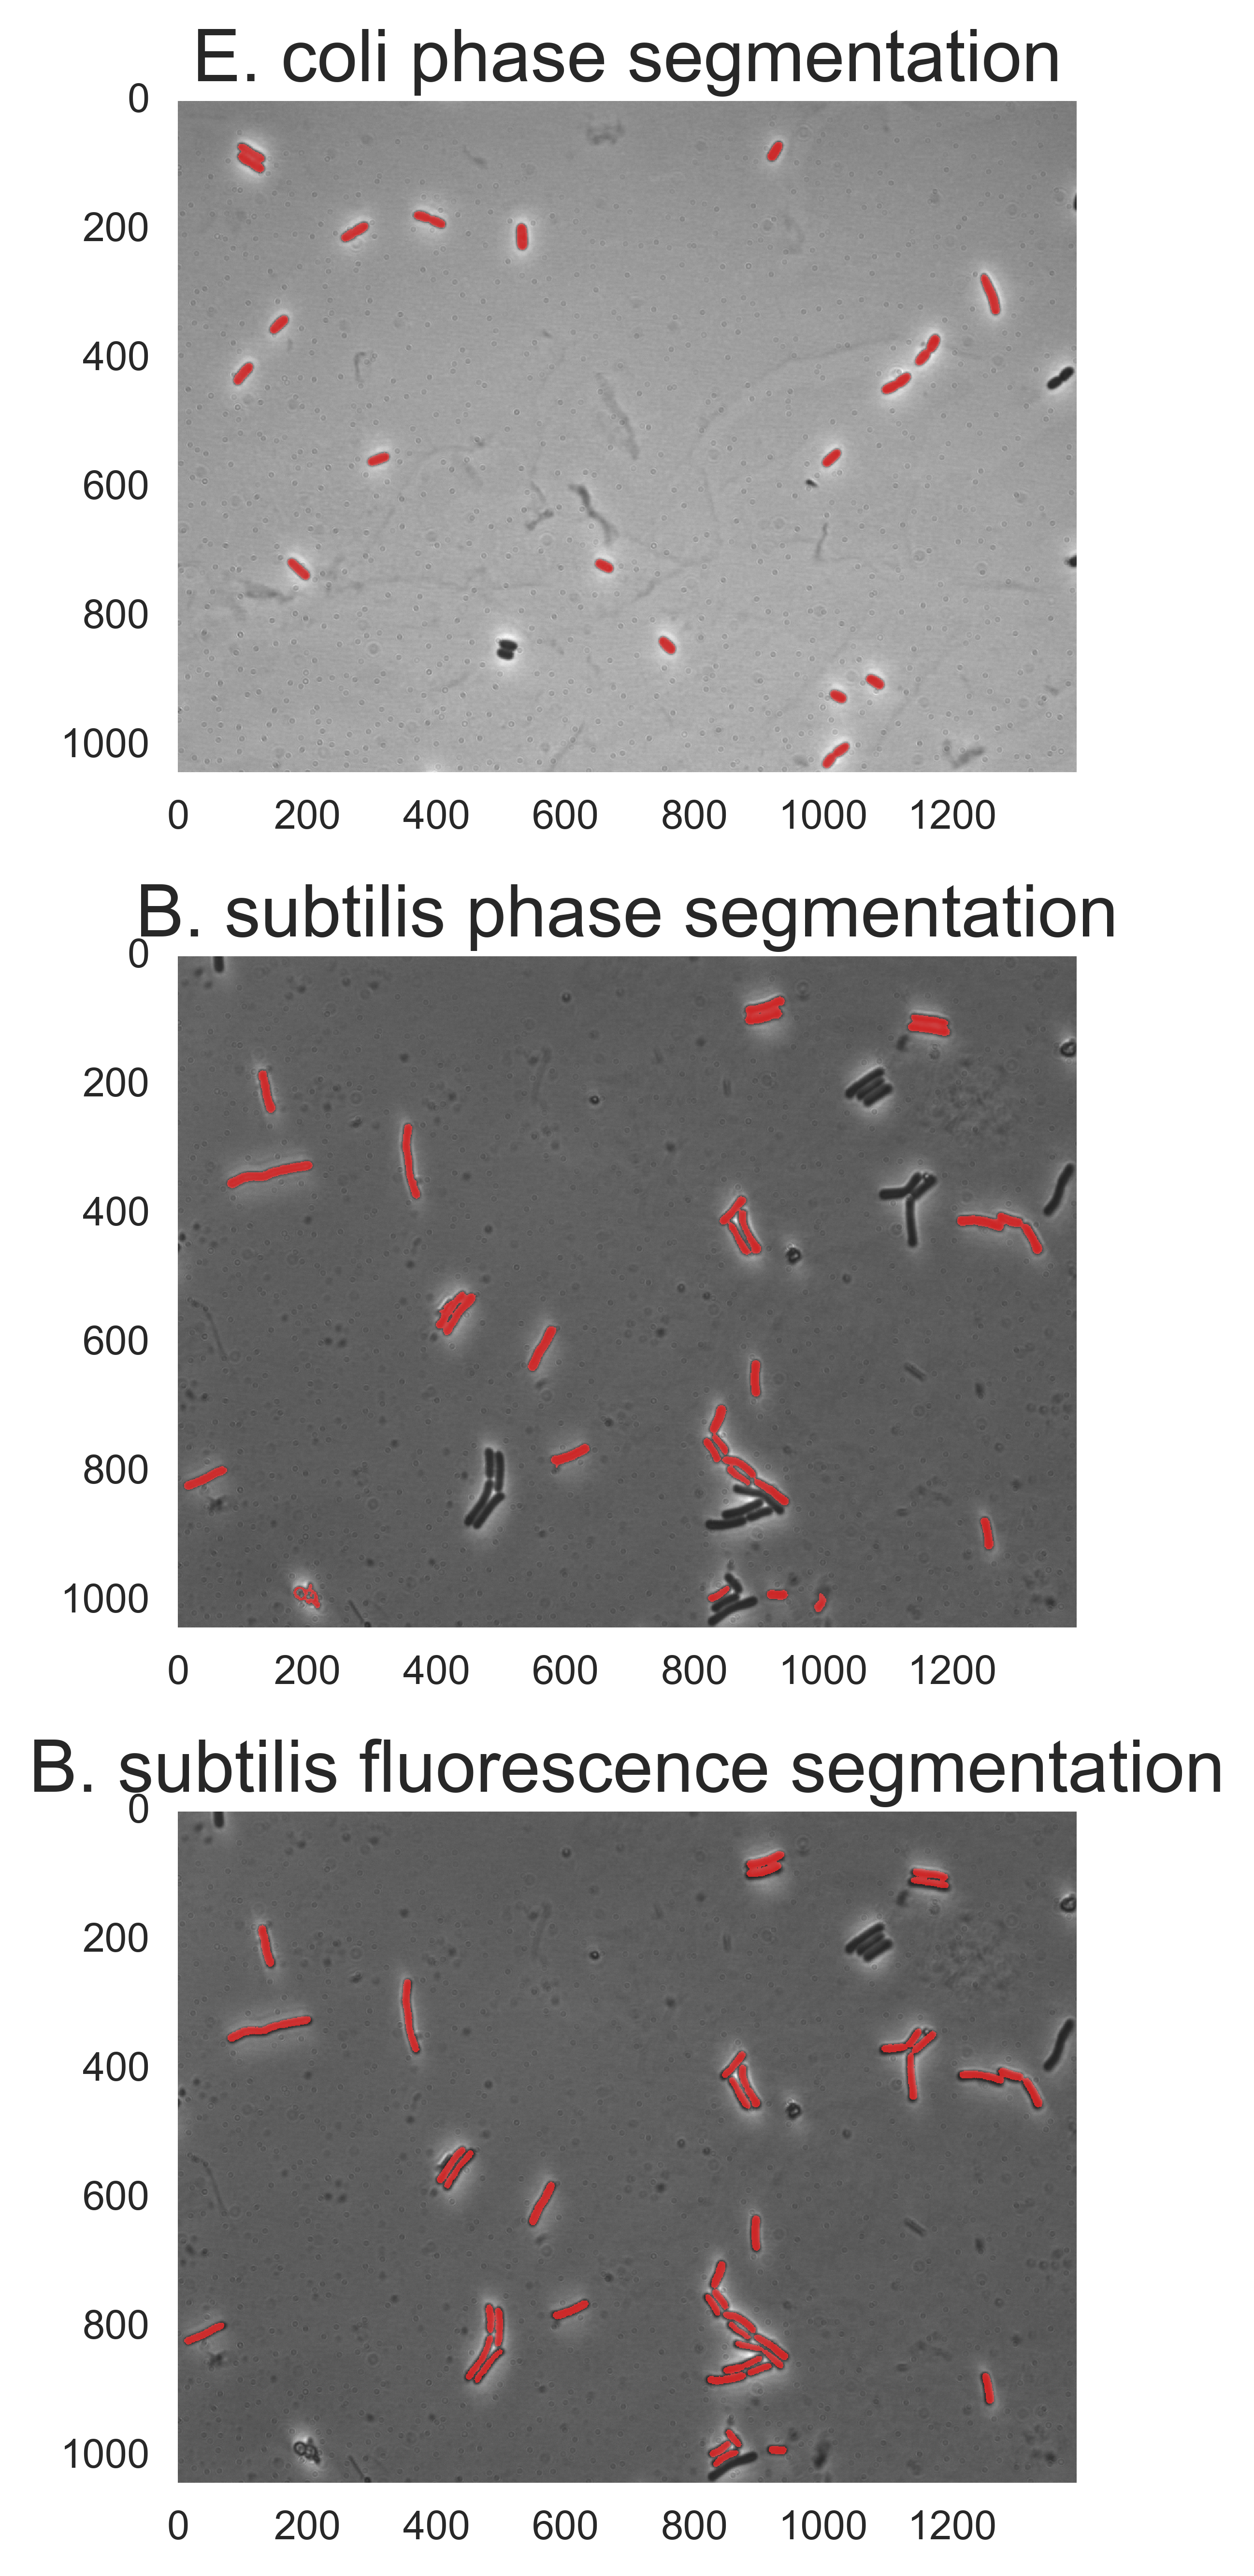

In [4]:
# Make the two phase images as floats and copy them.
ecoli_float = ecoli / ecoli.max()
bsub_float = bsub_phase / bsub_phase.max()
ecoli_copy = np.copy(ecoli_float)
bsub_copy = np.copy(bsub_float)
bsub_copy2 = np.copy(bsub_float)

# Mark the segmented bacteria on the copied images.
ecoli_copy[ecoli_seg > 0] = 0.8
bsub_copy[bsub_phase_seg > 0] = 0.8
bsub_copy2[bsub_fluo_seg > 0] = 0.8

# Merge them into RGB images.
ecoli_merge = np.dstack((ecoli_copy, ecoli_float, ecoli_float))
bsub_phase_merge = np.dstack((bsub_copy, bsub_float, bsub_float))
bsub_fluo_merge = np.dstack((bsub_copy2, bsub_float, bsub_float))

# Let's plot 'em!
with sns.axes_style('dark'):
    fig, ax = plt.subplots(3,1, figsize=(5,9))
    ax[0].imshow(ecoli_merge)
    ax[0].set_title('E. coli phase segmentation')
    ax[1].imshow(bsub_phase_merge)
    ax[1].set_title('B. subtilis phase segmentation')
    ax[2].imshow(bsub_fluo_merge)
    ax[2].set_title('B. subtilis fluorescence segmentation')
    plt.tight_layout()

That's actually pretty good! It's obvious that segmenting in fluorescence yields a better mask than in phase. Keep that in mind for your own experiments!

## Practice 2: Extracting fluorescence information

In the previous two lessons, we learned how to identify cellular objects in an image that is mostly non-cellular. However, we did not cover how you would extract information from one image (such as the fluorescence image) given a segmentation mask generated from another. Your goal for this practice session is to extract either the mean fluorescence intensity or (for bonus points) the total fluorescence intensity of each cell in our Lesson 39 *E. coli* image. To do this, you should. 

>1. Read the documentation for [skimage.measure.regionprops](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) and see what properties you can extract given an intensity image and a segmentation mask.
2. Using your segmentation mask generated from question 1, extract and store the mean and/or total fluorescence intensity for each cell in a single image in an array or pandas `DataFrame`.
3. Generate a histogram of your extracted intensities. 

Can you get a good idea of how bright a standard cell is from processing a single image?

### Practive 2: Solution 

Looking at the documentation (as well as in our [lesson 39 module](http://justinbois.github.io/bootcamp/2016/lessons/l39_segmentation.html), we see that to extract fluorescence images directly into the `skimage.measure.regionprops` function as the keyword argument `intensity_image`. Let's use the labeled segmentation mask produced from our `cell_segmenter` function to extract some fluorescence information from the image. For us, the most important quantity will be the mean fluorescence intensity of each region (cell).  

In [5]:
# Load the fluorescence image.
ecoli_yfp = skimage.io.imread('data/HG105_images/noLac_FITC_0004.tif')

# Compute the regionproperties of our fluorescence image. 
props = skimage.measure.regionprops(ecoli_seg, intensity_image=ecoli_yfp)

# Extract the mean intensities
mean_int = np.array([prop.mean_intensity for prop in props])

In the literature, you will probably see both the *mean fluorescence intensity*  and the *total integrated intensity* used to report expression of some fluorophore. It's important to realize that these can have different meanings depending on the size distribution of your cells and you should think carefully about what the relevant parameters are that you are looking to measure. In our case, there will not be too large of a difference, but we will look at the mean intensities.

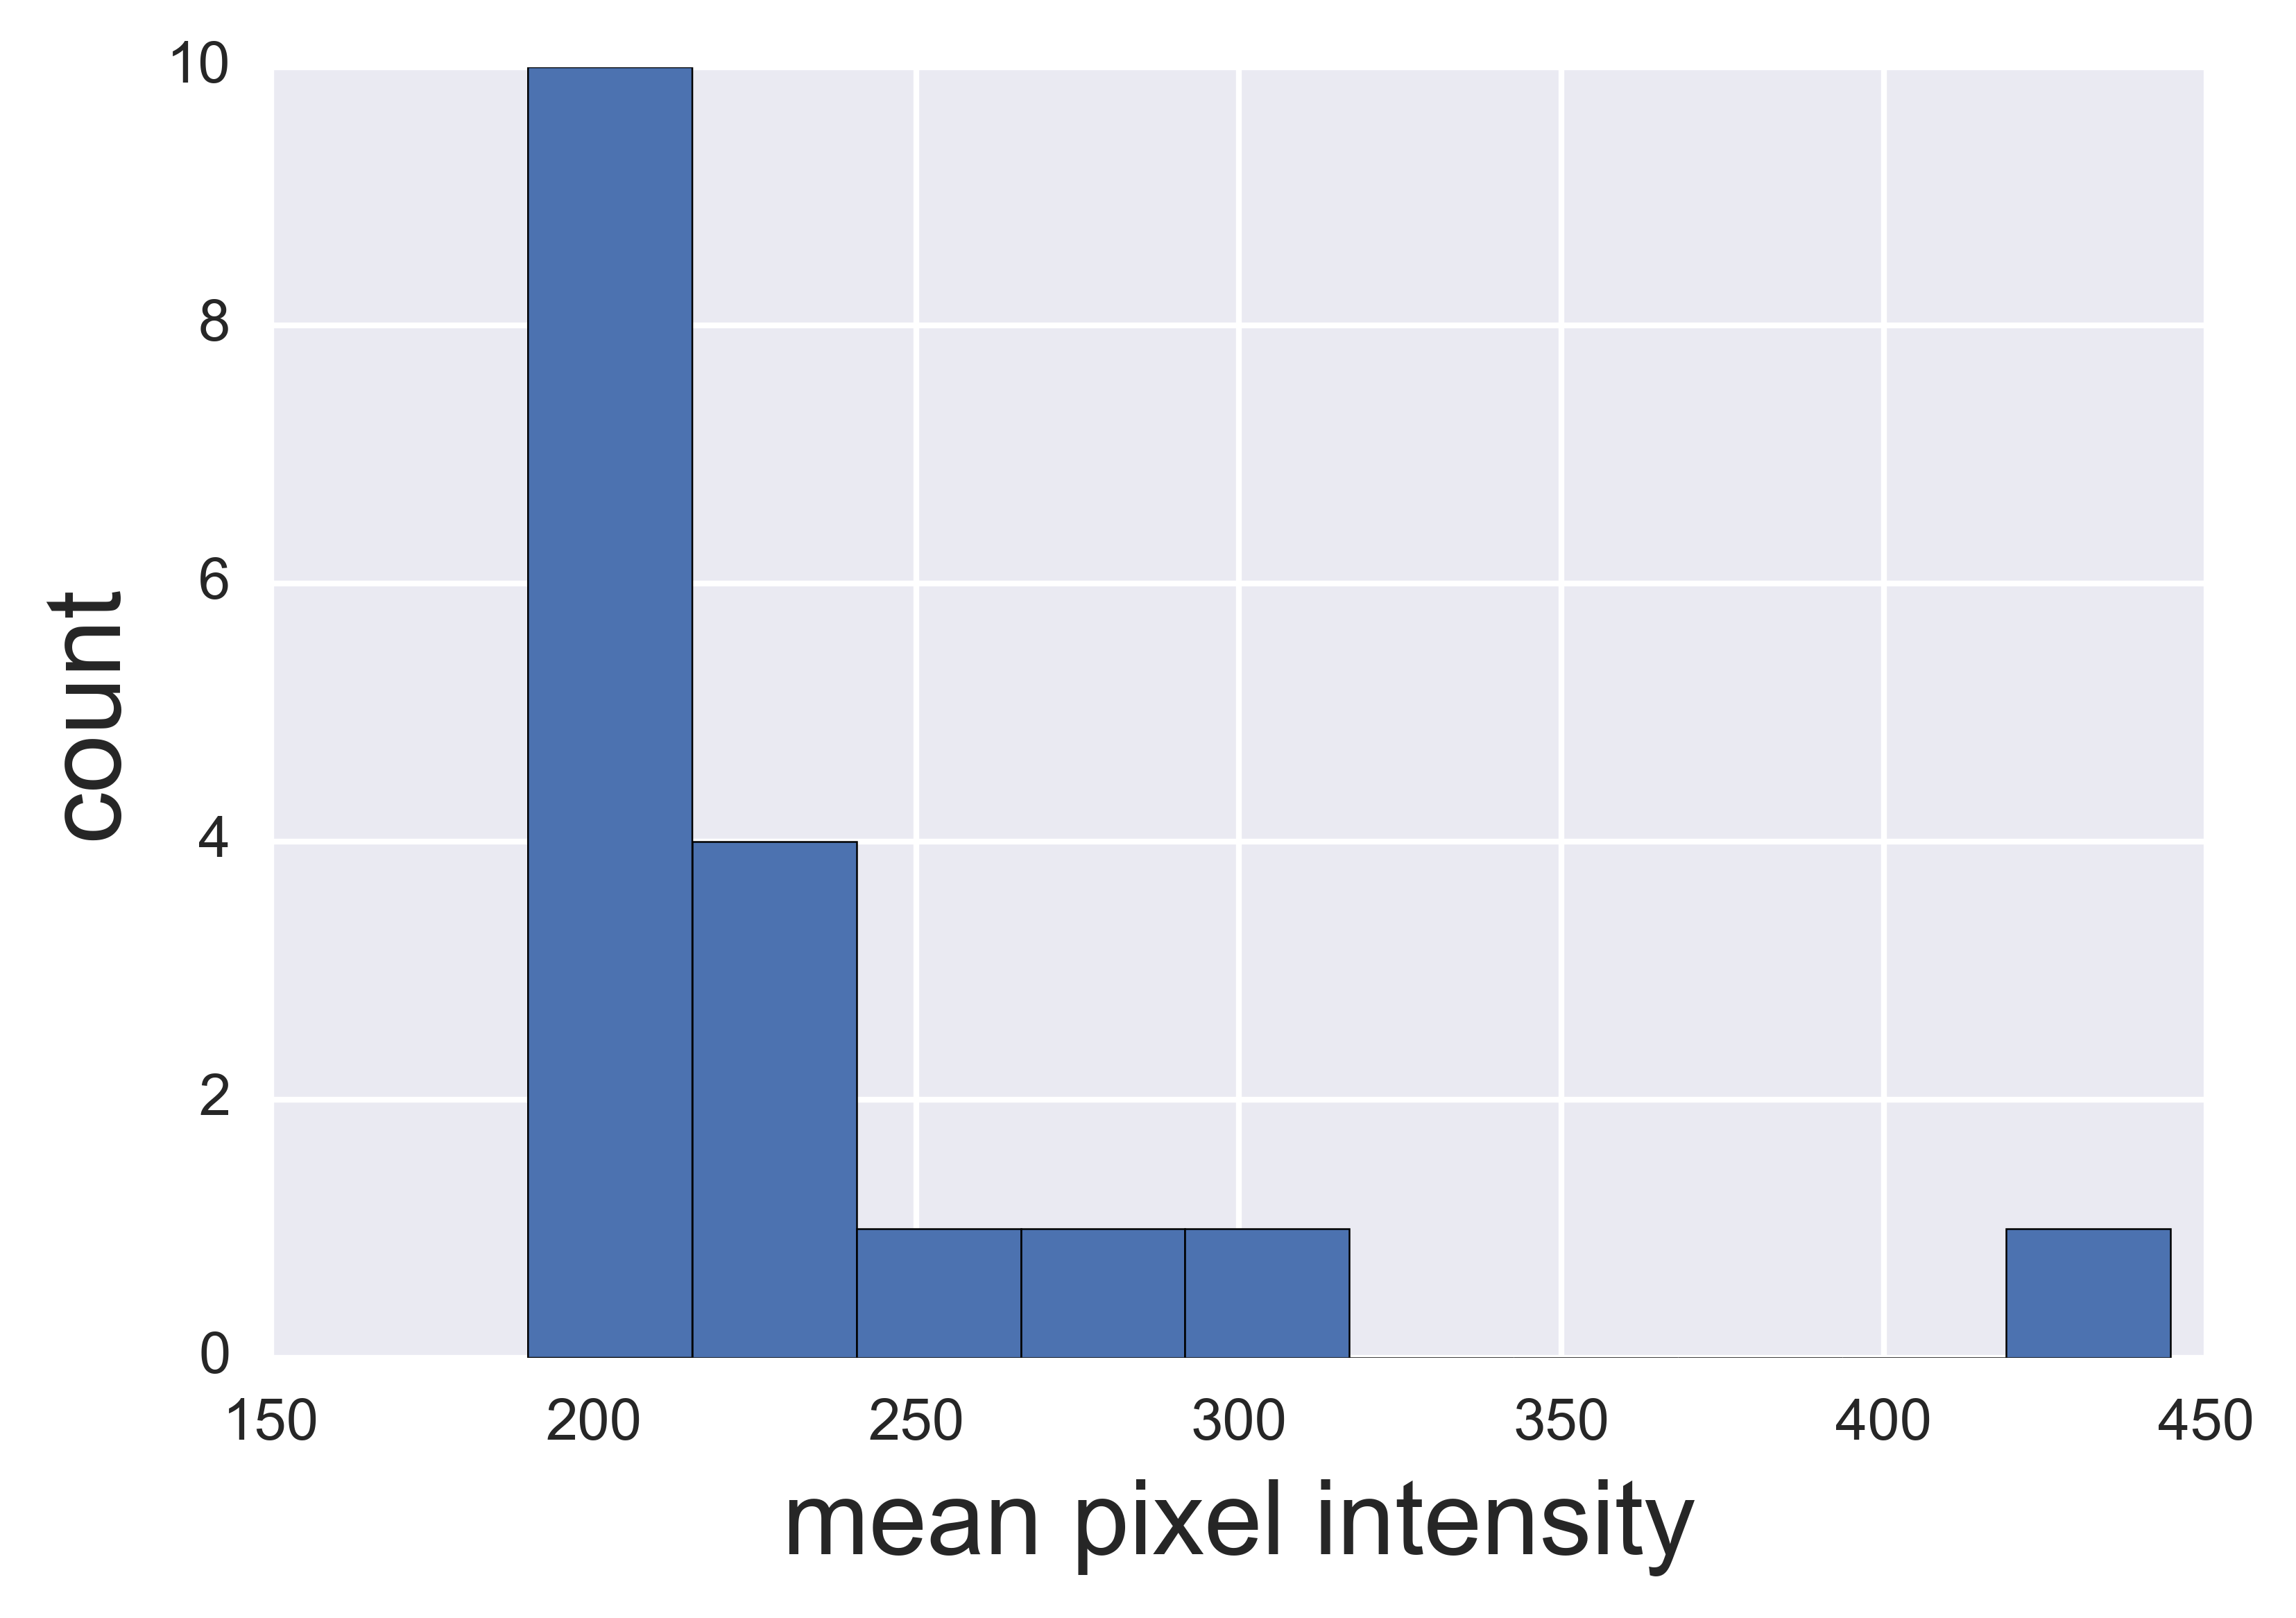

In [6]:
# We'll start with a simple histogram.
plt.hist(mean_int)
plt.xlabel('mean pixel intensity')
plt.ylabel('count')

 It seems from our plot above that there is a range of expression values but most cells seem to be around 200 counts. With such a small sample of cells, however, it is hard to say anything with certainty. In fact, changing the binning will wildly change the way the data appears to be distributed. To counteract this bin bias, let's take a look at the ECDF.

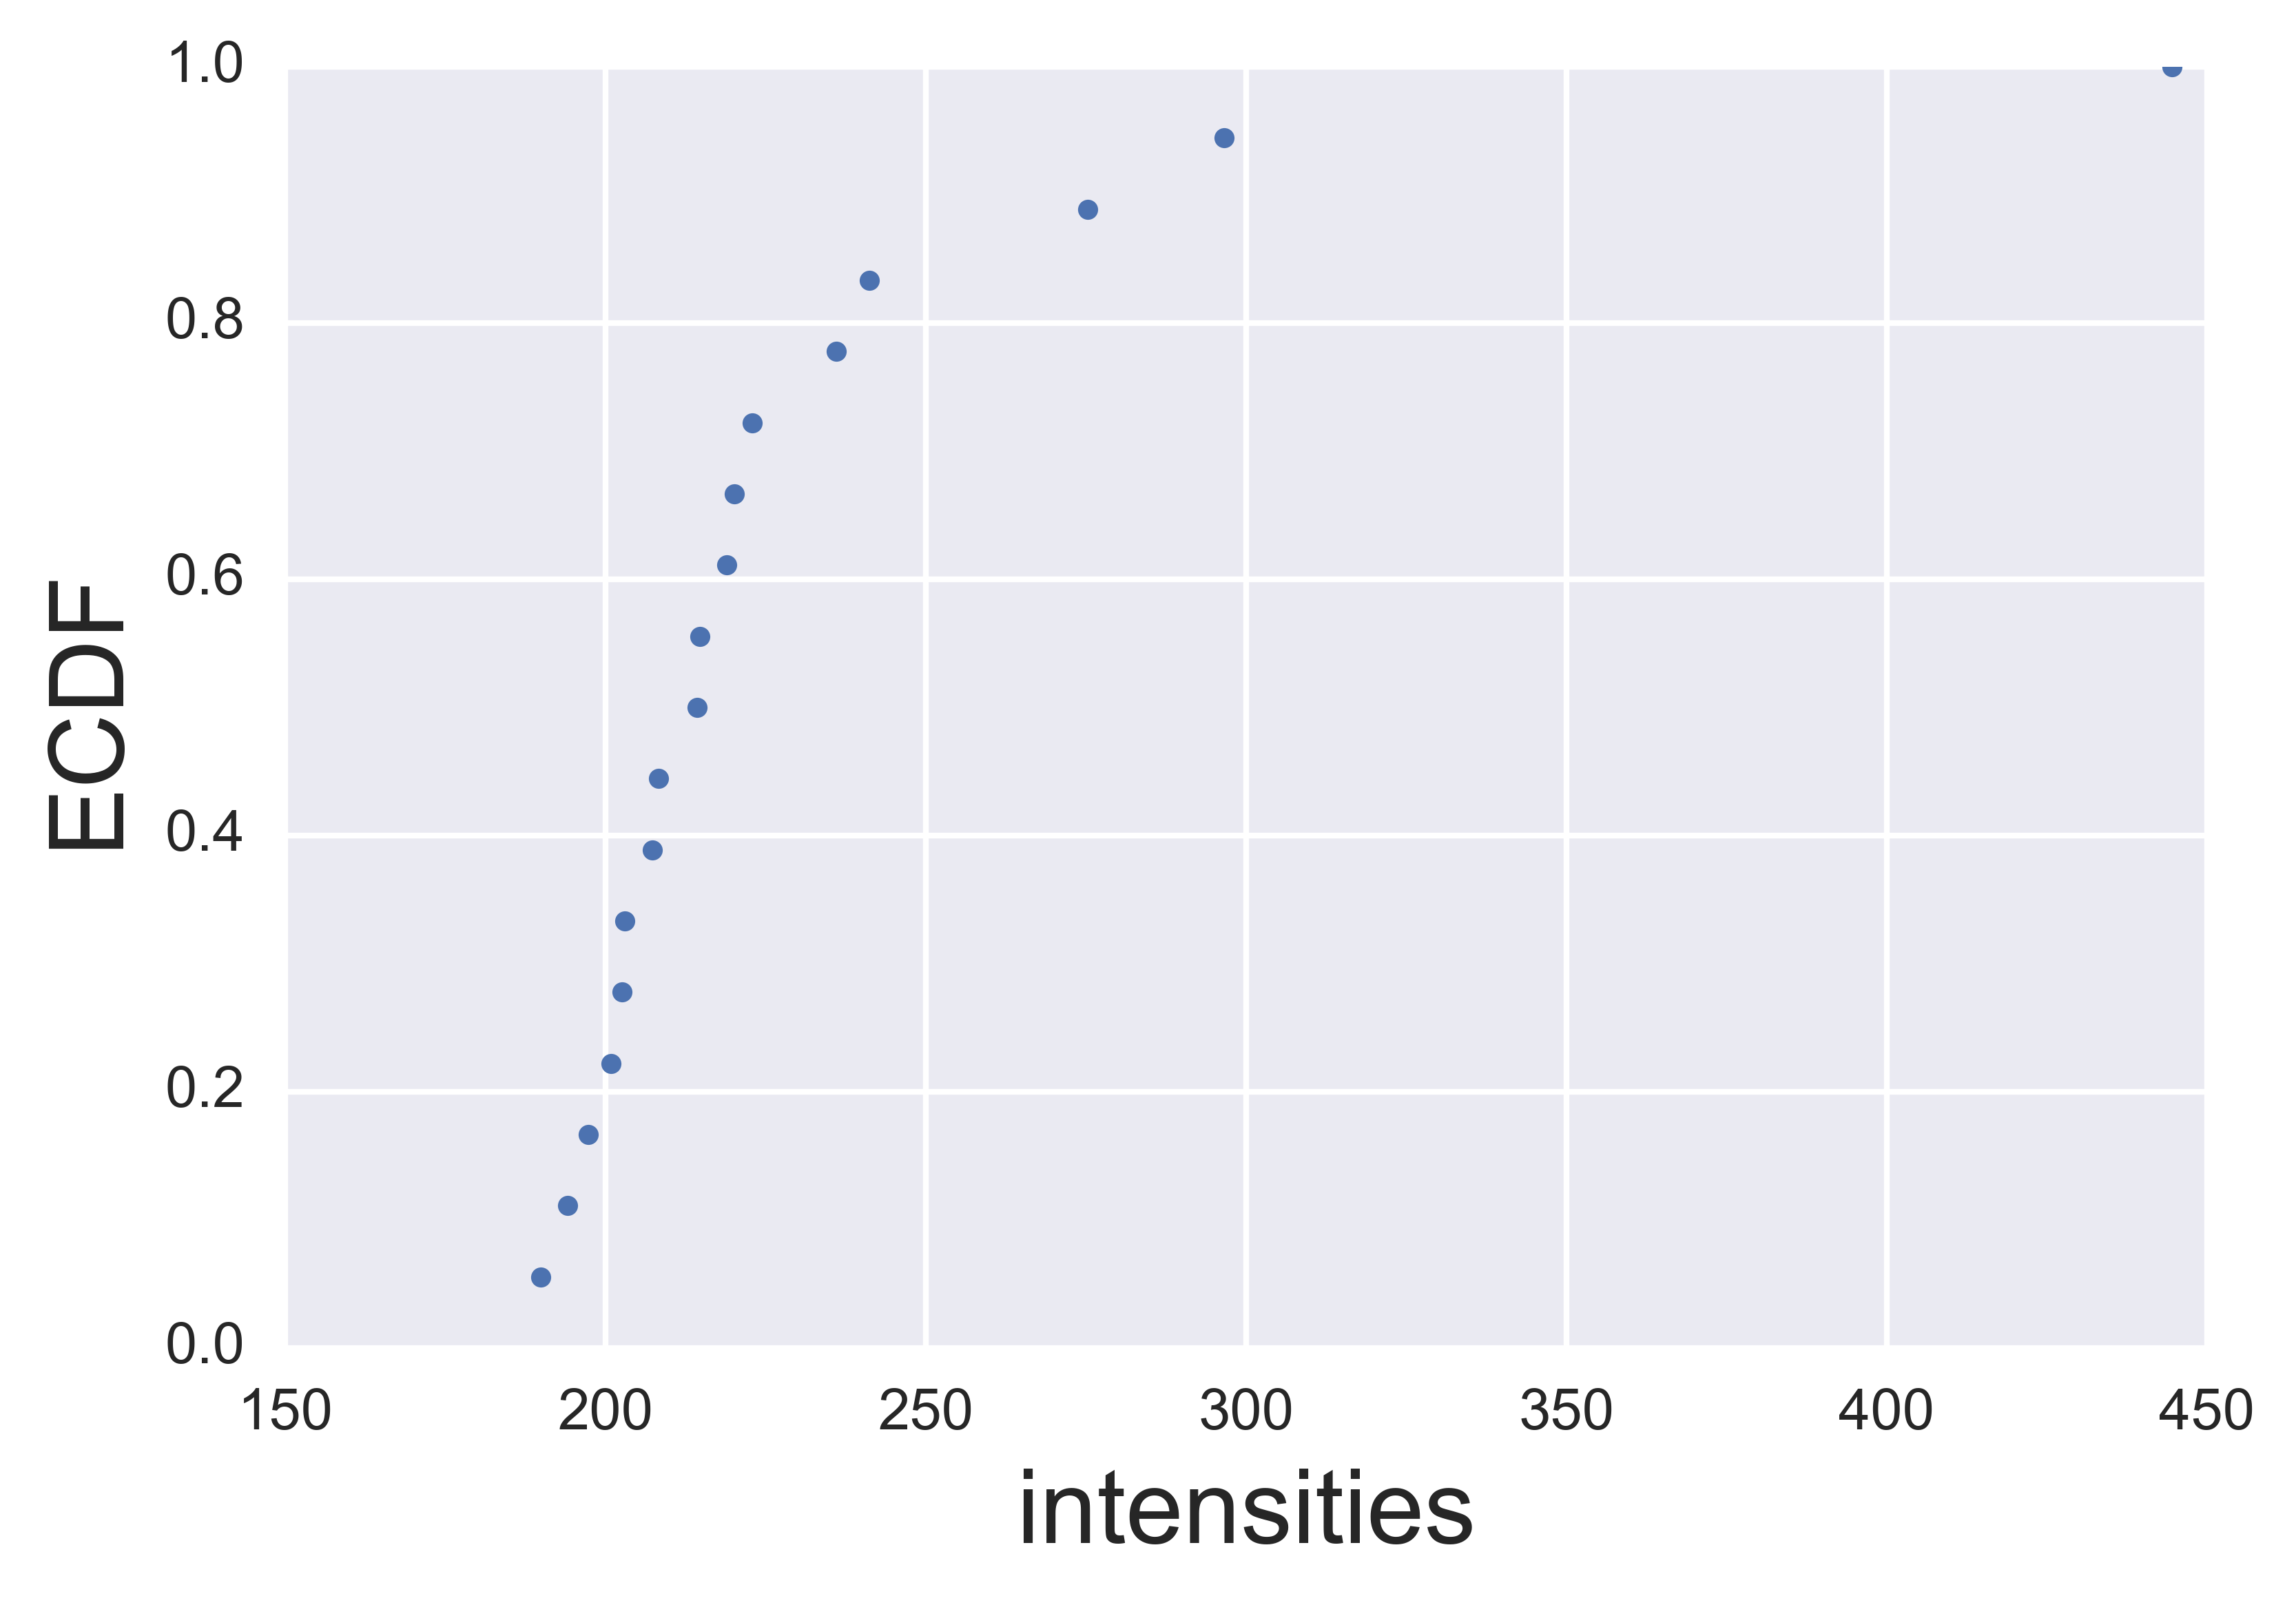

In [8]:
# Define our function for computing the ECDF.
def ecdf(data):
    """Compute x, y values for an empirical distribution function."""
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

# Compute the ECDF for our glow-y cells. 
intensities, ECDF = ecdf(mean_int)

# Plot it. 
plt.plot(intensities, ECDF, marker='.', linestyle='none')
plt.xlabel('intensities')
plt.ylabel('ECDF')

While we have a better picture of the distribution with the ECDF, it's still pretty hard to draw any conclusions from a single image. We could continue the experiment and analyze the other images (which is a problem in the following exercise) or we could flex our bootstrap biceps. Let's give it a shot.  

In [9]:
# Define our number of repettitions.
n_reps = 100000

# Initialize our replicates.
bootstrap_means = np.empty(n_reps)

# Compute our replicates. We'll plot each bootstrap as we go along
for i in range(n_reps):
    resample = np.random.choice(mean_int, replace=True, size=len(mean_int))
    bootstrap_means[i] = np.mean(resample)

Let's take a look at the distribution of means as well.

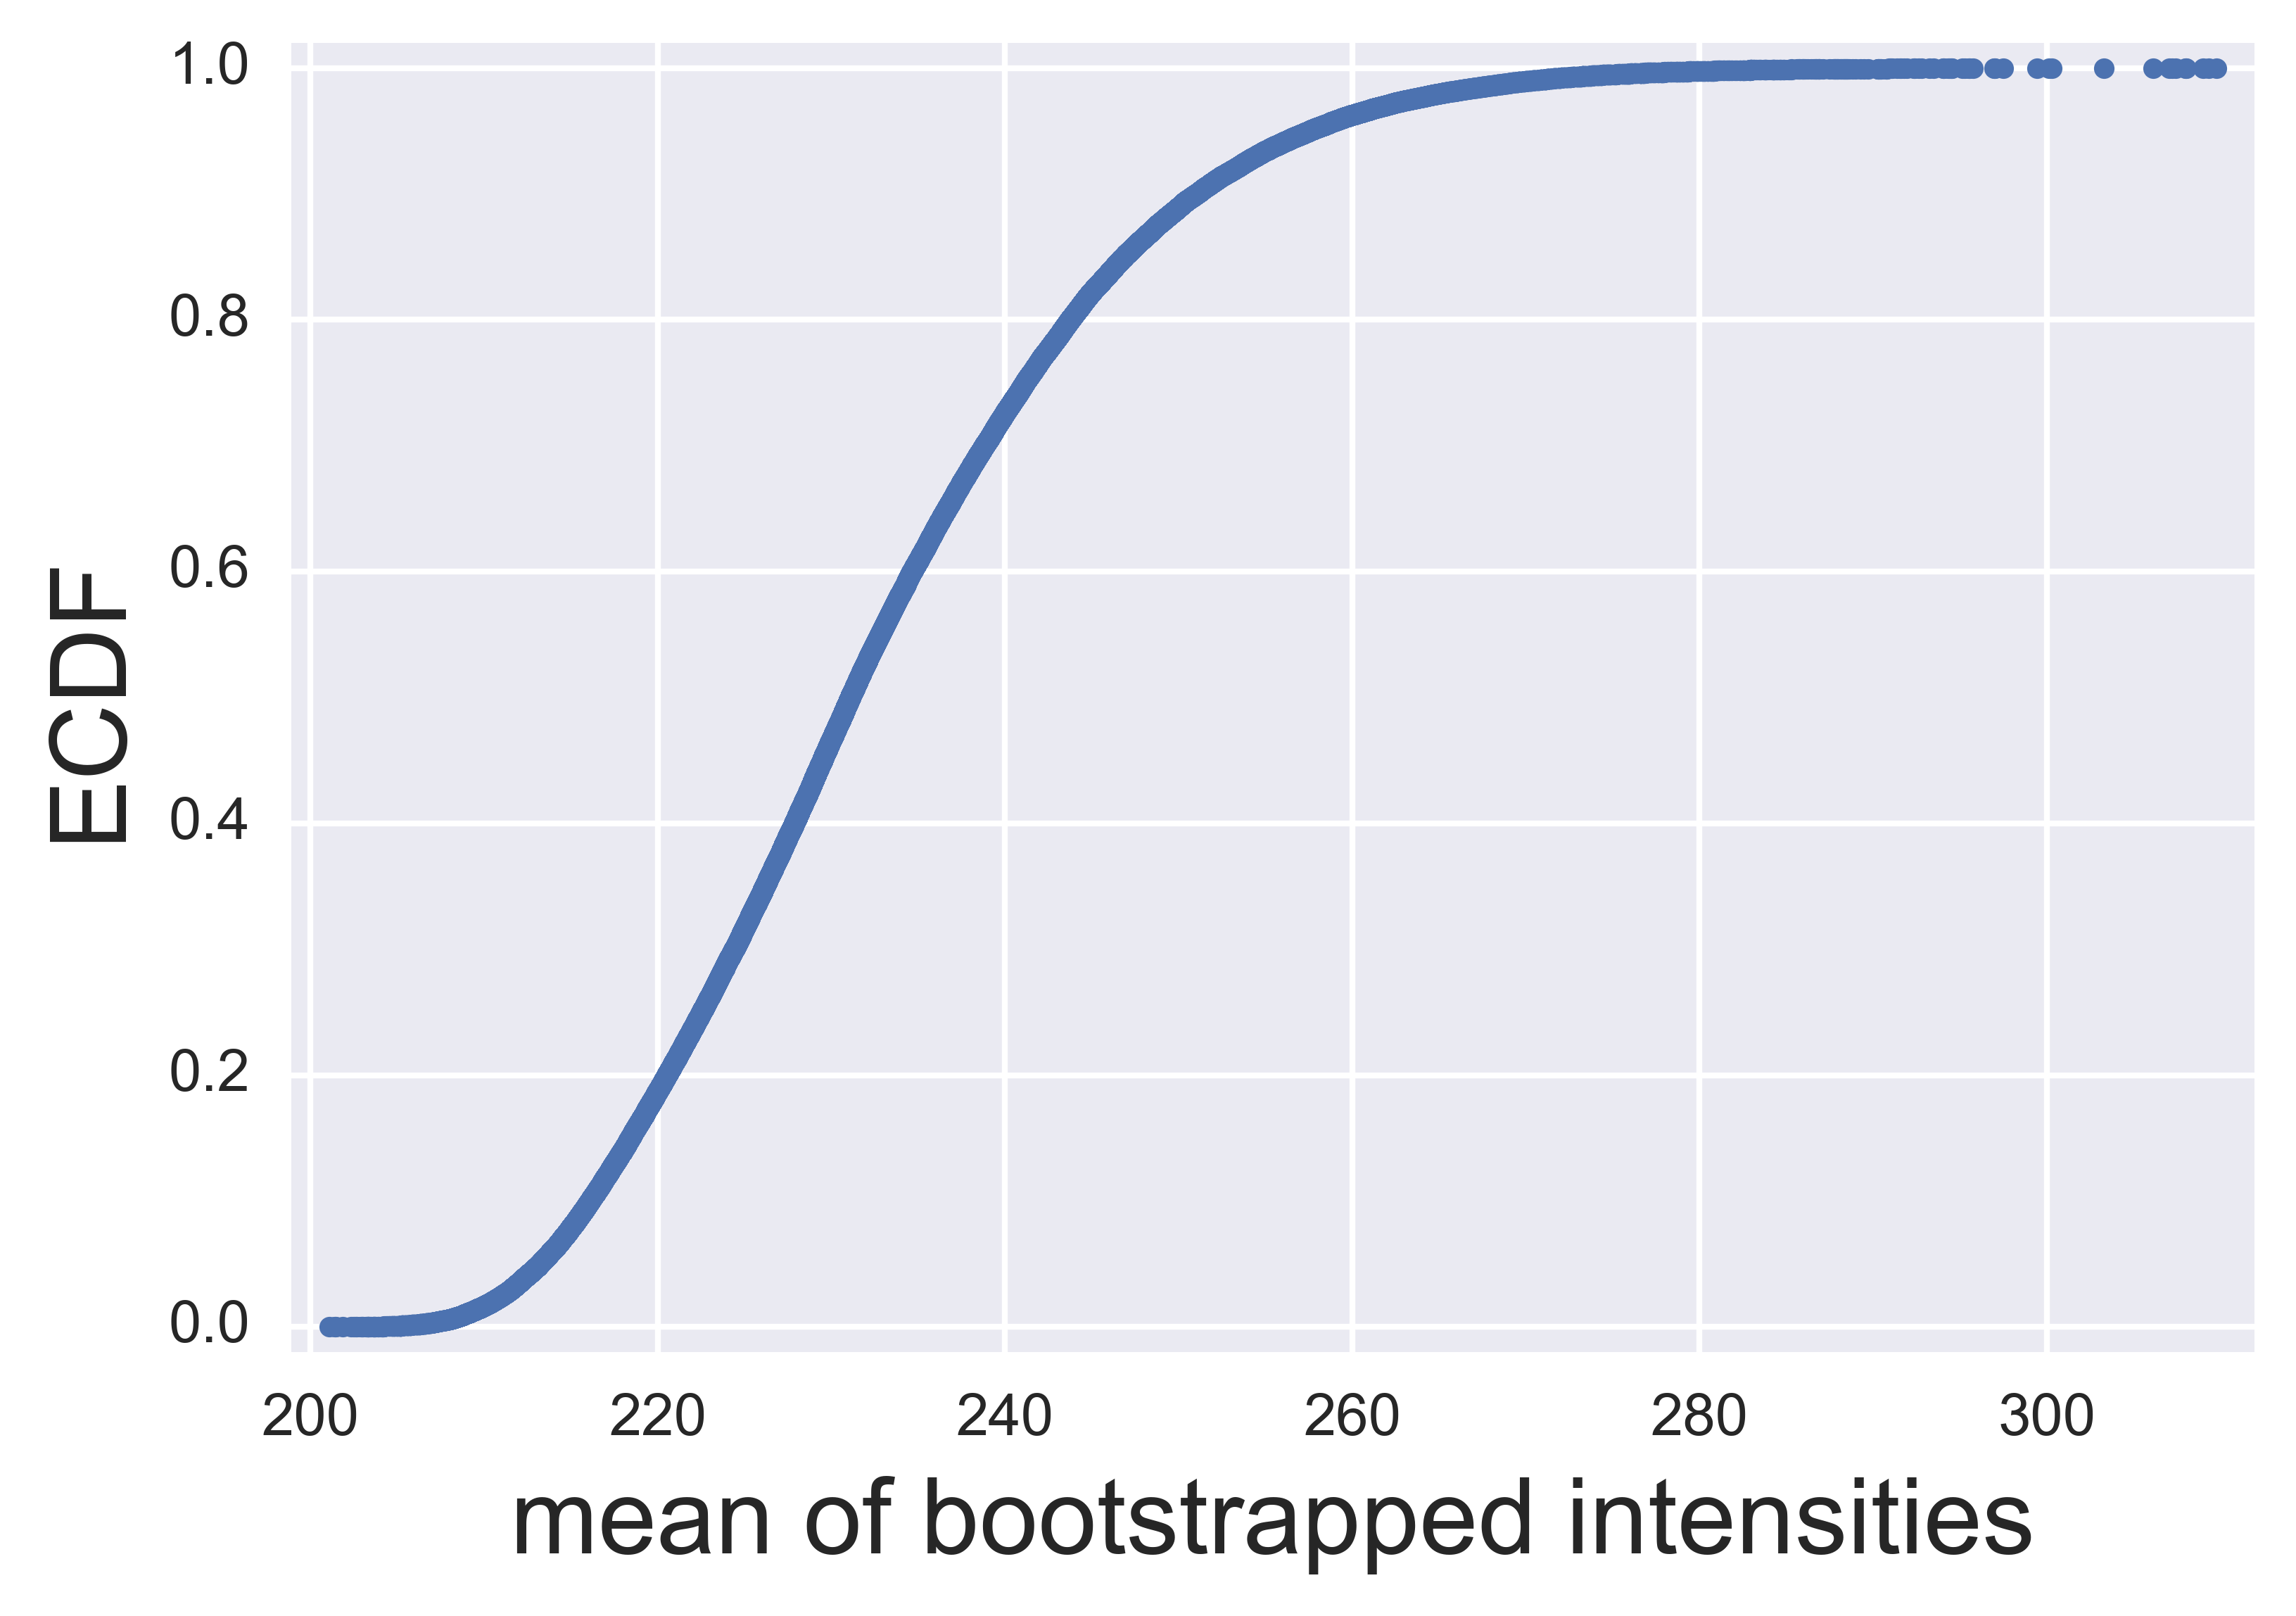

In [13]:
# Compute the ECDF
bs_means, bs_ECDF = ecdf(bootstrap_means)
plt.plot(bs_means, bs_ECDF, marker='.', linestyle='none')
plt.xlabel('mean of bootstrapped intensities')
plt.ylabel('ECDF')
plt.margins(0.02)

That looks fairly gaussian. Let's compute our 95% confidence interval. 

In [14]:
# Compute the 95% confidence interval
percs = np.percentile(bootstrap_means, [97.5, 2.5])

print("""
The 97.5% and the 2.5% of the bootstrapped data are {0:.3f}
and {1:.3f}, respectively.
""".format(percs[0], percs[1]))


The 97.5% and the 2.5% of the bootstrapped data are 263.342
and 211.043, respectively.

